In [1]:
import hdcms as hdc
import re
import random
import numpy as np
from PIL import Image
from hdcms.visualize import ImageConfig
np.set_printoptions(precision=3, linewidth=99999999999)
random.seed(420)

```
+-----------------------------------------------------+
|                 180 replicates                      |
+-----------------+-----------------+-----------------+
|     60 reps     |     60 reps     |     60 reps     |
|      Meta       |     Ortho       |       Para      |
+-----------------+-----------------+-----------------+
|A |B |C |D |E |F |A |B |C |D |E |F |A |B |C |D |E |F |
|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|
+-----------------------------------------------------+
```

this is the layout of the data

In [2]:
DATA = "/Users/jason/.root/time/sem06/nist/WVU/FF_me/"
compounds = ["Meta", "Ortho", "Para"]
labs = ["A", "B", "C", "D", "E", "F"]
def f2stats(arg):
    sum_stat = hdc.filenames2stats2d(arg)
    return sum_stat[sum_stat[:,1] != 0]
#     return hdc.filenames2stats1d(arg)

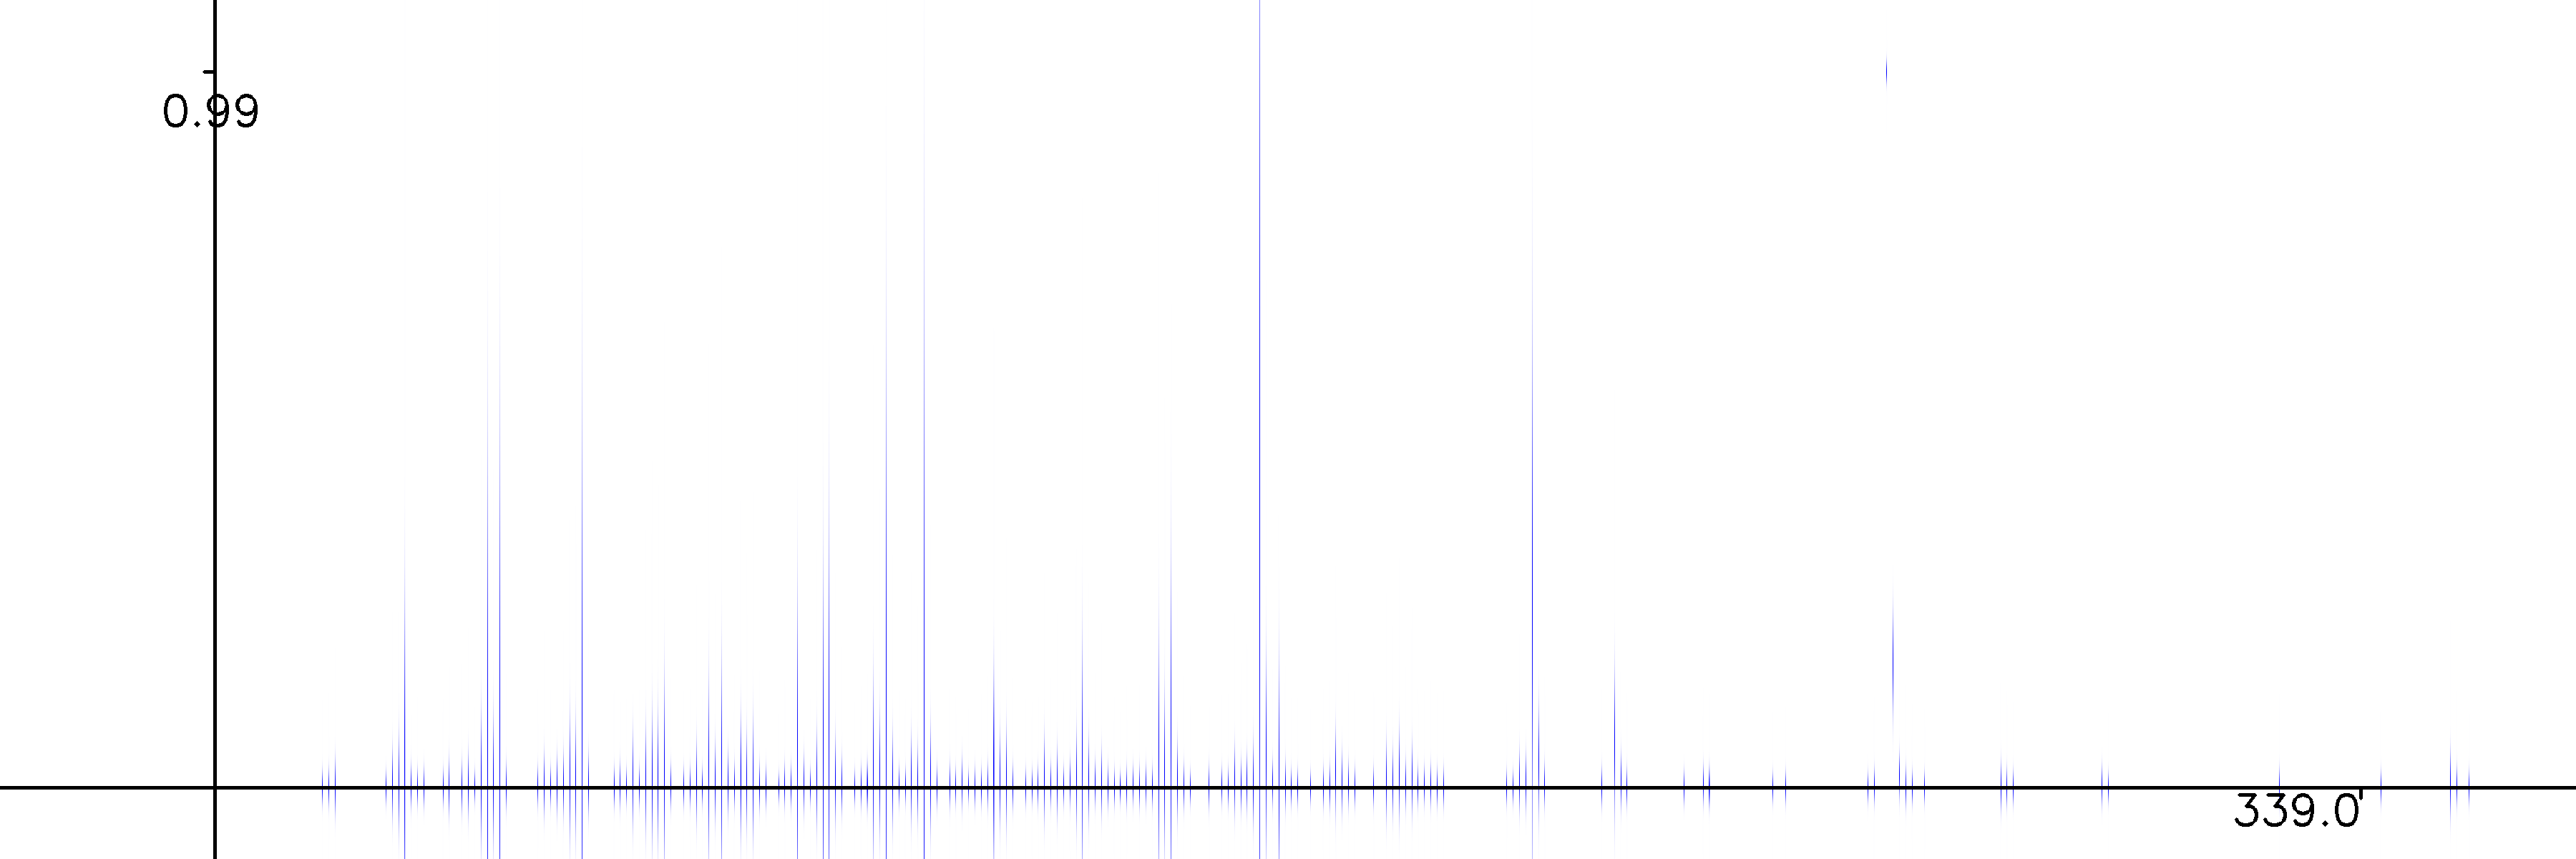

In [10]:
lab_b_meta = hdc.regex2stats2d(r"B_Meta-\d[AB].txt", dir=DATA)
# remove 0 peaks (since her data is weird)
lab_b_meta = lab_b_meta[lab_b_meta[:,1] != 0]
conf = ImageConfig(std_scale=10, desingularization=1e-2)
im = Image.fromarray(hdc.write_image(lab_b_meta, config=conf))
display(im)

In [4]:
# helper functions

def rand_sel(input, div=-1):
    """div=-1 means half in this case"""
    l = input.copy()
    if div == -1:
        div = len(l)//2
    random.shuffle(l)
    return l[:div], l[div:]

def get_filenames(compound, lab, dir=DATA):
    """ex: get_filenames("Meta", "A")
    this would get all replicates from lab A, for Meta-FF
    
    get_filenames("Ortho", ".")
    this would take a random 5 replicates from all labs for Ortho-FF
    """
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    r = re.compile(lab + "_" + compound + r"-\d[AB].txt")
    matches = []
    for f in files:
        match = r.match(f)
        if match:
            matches.append(f)
    
    if len(matches) == 0:
        raise RuntimeError(f"No matches for {regex} in directory {dir}")
    final = list(map(lambda f: os.path.join(dir, f), matches))
    return final

def remove_diag(input):
    mat = np.copy(input)
    assert(mat.shape[0] == mat.shape[1])
    for i in range(mat.shape[0]):
        mat[i,i] = 0
    return mat

In [5]:
bad_count = 0
total = 0

print("PER LAB 10 SAMPLES VS N-10 SAMPLES (excluding lab)")
print(f"compounds: {compounds}")
for compound in compounds:
    for lab in labs:
        lab_list = get_filenames(compound, lab)
        assert(len(lab_list) == 10)
        lab_reps = ','.join(lab_list)
        lab_stat = f2stats(lab_reps)
        
        compounds_excluding_lab = []
        for new_compound in compounds:
            if compound == new_compound:
                new_lab = "[^"+lab+"]" # not our lab
            else:
                new_lab = "." # anything
            new_list = get_filenames(new_compound, new_lab)
            assert(len(new_list) == 50 or len(new_list) == 60)
            sel, _ = rand_sel(new_list, div=10)
            assert(len(sel) == 10)
            reps = ','.join(sel)
            compounds_excluding_lab.append(f2stats(reps))
        mat = hdc.compare(lab_stat, *compounds_excluding_lab, npeaks=5)
        most_sim = np.argmax(remove_diag(mat),axis=1)[0] # this gets argmax of first row
        goal_ind = compounds.index(compound)+1
        
        print(f"lab: {lab}, compound: {compound}", end=" ")
        total += 1
        if goal_ind != most_sim:
            bad_count += 1
            print("HELP:", mat[0,1:])
        else:
            print("GOOD!", mat[0,1:])

print(bad_count, '/', total, '=', f"{str(100 - bad_count/total * 100)[:4]}%")

PER LAB 10 SAMPLES VS N-10 SAMPLES (excluding lab)
compounds: ['Meta', 'Ortho', 'Para']
lab: A, compound: Meta GOOD! [0.967 0.854 0.872]
lab: B, compound: Meta GOOD! [0.955 0.819 0.925]
lab: C, compound: Meta GOOD! [0.82  0.816 0.815]
lab: D, compound: Meta GOOD! [0.965 0.863 0.955]
lab: E, compound: Meta GOOD! [0.956 0.832 0.954]
lab: F, compound: Meta GOOD! [0.872 0.811 0.823]
lab: A, compound: Ortho HELP: [0.882 0.84  0.911]
lab: B, compound: Ortho HELP: [0.92  0.951 0.962]
lab: C, compound: Ortho GOOD! [0.754 0.865 0.734]
lab: D, compound: Ortho GOOD! [0.763 0.855 0.747]
lab: E, compound: Ortho GOOD! [0.872 0.937 0.896]
lab: F, compound: Ortho GOOD! [0.77  0.824 0.776]
lab: A, compound: Para HELP: [0.879 0.774 0.86 ]
lab: B, compound: Para GOOD! [0.958 0.882 0.98 ]
lab: C, compound: Para HELP: [0.902 0.944 0.904]
lab: D, compound: Para GOOD! [0.935 0.9   0.956]
lab: E, compound: Para GOOD! [0.956 0.878 0.968]
lab: F, compound: Para HELP: [0.892 0.819 0.882]
5 / 18 = 72.2%


In [6]:
def perlab10():
    print("PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)")
    bad_count = 0
    total = 0

    print(f"compounds: {compounds}")
    for compound in compounds:
        for lab in labs:
            lab_list = get_filenames(compound, lab)
            assert(len(lab_list) == 10)
            lab_reps = ','.join(lab_list)
            lab_stat = f2stats(lab_reps)

            compounds_excluding_lab = []
            for new_compound in compounds:
                if compound == new_compound:
                    new_lab = "[^"+lab+"]" # not our lab
                else:
                    new_lab = "." # anything
                new_list = get_filenames(new_compound, new_lab)
                assert(len(new_list) == 50 or len(new_list) == 60)
                if compound == new_compound:
                    sel = new_list
                else:
                    # drop 10 reps if another comound so everything has 50 (so we don't bias toward/away from original compound)
                    _, sel = rand_sel(new_list, div=10)
                assert(len(sel) == 50)
                reps = ','.join(sel)
                compounds_excluding_lab.append(f2stats(reps))
            mat = hdc.compare(lab_stat, *compounds_excluding_lab)
            most_sim = np.argmax(remove_diag(mat),axis=1)[0] # this gets argmax of first row
            goal_ind = compounds.index(compound)+1

            print(f"lab: {lab}, compound: {compound}", end=" ")
            total += 1
            if goal_ind != most_sim:
                bad_count += 1
                print("HELP:", mat[0,1:])
            else:
                print("GOOD!", mat[0,1:])

    print(bad_count, '/', total, '=', f"{str(100 - bad_count/total * 100)[:4]}%")
# %lprun -f perlab10 perlab10()
perlab10()

PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)
compounds: ['Meta', 'Ortho', 'Para']
lab: A, compound: Meta GOOD! [0.948 0.833 0.94 ]
lab: B, compound: Meta HELP: [0.956 0.84  0.963]
lab: C, compound: Meta HELP: [0.796 0.853 0.839]
lab: D, compound: Meta GOOD! [0.966 0.876 0.957]
lab: E, compound: Meta GOOD! [0.96  0.832 0.948]
lab: F, compound: Meta GOOD! [0.868 0.816 0.843]
lab: A, compound: Ortho HELP: [0.884 0.877 0.918]
lab: B, compound: Ortho HELP: [0.937 0.911 0.961]
lab: C, compound: Ortho GOOD! [0.758 0.841 0.755]
lab: D, compound: Ortho GOOD! [0.761 0.832 0.745]
lab: E, compound: Ortho GOOD! [0.91  0.943 0.937]
lab: F, compound: Ortho GOOD! [0.751 0.839 0.777]
lab: A, compound: Para HELP: [0.898 0.788 0.869]
lab: B, compound: Para GOOD! [0.95  0.853 0.969]
lab: C, compound: Para HELP: [0.899 0.921 0.91 ]
lab: D, compound: Para GOOD! [0.918 0.91  0.951]
lab: E, compound: Para GOOD! [0.959 0.853 0.961]
lab: F, compound: Para GOOD! [0.889 0.879 0.89 ]
6 / 18 = 66.6%


In [7]:
# all this cell does is count replicates
print("COUNT REPS: PER LAB 10 SAMPLES VS ALL-10 SAMPLES (excluding lab)")
# print(f"compounds: {compounds}")
lib_num_reps = []
query_num_reps = []
for compound in compounds:
    for lab in labs:
#         print(f"compound: {compound}, lab: {lab}")
        lab_list = get_filenames(compound, lab)
        assert(len(lab_list) == 10)
        lab_reps = ','.join(lab_list)
        lab_stat = f2stats(lab_reps)
        query_num_reps.append(np.count_nonzero(lab_stat[:, 0]))
        
        for new_compound in compounds:
            if compound == new_compound:
                new_lab = "[^"+lab+"]" # not our lab
            else:
                new_lab = "." # anything
            new_list = get_filenames(new_compound, new_lab)
            assert(len(new_list) == 50 or len(new_list) == 60)
            sel, _ = rand_sel(new_list, div=10)
            assert(len(sel) == 10)
            reps = ','.join(sel)
            sum_stat = f2stats(reps)
            lib_num_reps.append(np.count_nonzero(sum_stat[:, 0]))

print(np.mean(np.array(lib_num_reps)))
print(np.mean(np.array(query_num_reps)))

COUNT REPS: PER LAB 10 SAMPLES VS ALL-10 SAMPLES (excluding lab)
223.94444444444446
205.66666666666666


In [8]:
# all this cell does is count replicates
print("PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)")
# print(f"compounds: {compounds}")
lib_num_reps = []
query_num_reps = []
for compound in compounds:
    for lab in labs:
#         print(f"compound: {compound}, lab: {lab}")
        lab_list = get_filenames(compound, lab)
        assert(len(lab_list) == 10)
        lab_reps = ','.join(lab_list)
        lab_stat = f2stats(lab_reps)
        query_num_reps.append(np.count_nonzero(lab_stat[:, 0]))

        for new_compound in compounds:
            if compound == new_compound:
                new_lab = "[^"+lab+"]" # not our lab
            else:
                new_lab = "." # anything
            new_list = get_filenames(new_compound, new_lab)
            assert(len(new_list) == 50 or len(new_list) == 60)
            if compound == new_compound:
                sel = new_list
            else:
                # drop 10 reps if another comound so everything has 50 (so we don't bias toward/away from original compound)
                _, sel = rand_sel(new_list, div=10)
            assert(len(sel) == 50)
            reps = ','.join(sel)
            sum_stat = f2stats(reps)
            lib_num_reps.append(np.count_nonzero(sum_stat[:, 0]))
            
print(np.mean(np.array(lib_num_reps)))
print(np.mean(np.array(query_num_reps)))

PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)
240.25925925925927
205.66666666666666
